In [1]:
import numpy as np
import pandas as pd
import tracktor as tr
import cv2
import sys
import scipy.signal
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist



In [2]:
# colours is a vector of BGR values which are used to identify individuals in the video
# s_id is spider id and is also used for individual identification
# since we only have two individuals, the program will only use the first two elements from these arrays (s_id and colours)
# number of elements in colours should be greater than n_inds (THIS IS NECESSARY FOR VISUALISATION ONLY)
# number of elements in s_id should be greater than n_inds (THIS IS NECESSARY TO GET INDIVIDUAL-SPECIFIC DATA)
n_inds = 1
s_id = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
colours = [(0,0,255),(0,255,255),(255,0,255),(0,0,0),(255,255,0),(255,0,0),(0,255,0),(255,255,255)]

# this is the block_size and offset used for adaptive thresholding (block_size should always be odd)
# these values are critical for tracking performance
block_size = 53
offset = 6 # 3 regularly comes up as a good value

threshold = 55 # for binary thresholding

# minimum area and maximum area occupied by the animal in number of pixels
# this parameter is used to get rid of other objects in view that might be hard to threshold out but are differently sized
# in this case, the range is wide because males vastly smaller than females
min_area = 1 # target 1500
max_area = 5000 # target 3500

# the scaling parameter can be used to speed up tracking if video resolution is too high (use value 0-1)
scaling = 1.0

# kernel for erosion and dilation
# useful since thin spider limbs are sometimes detected as separate objects
kernel = np.ones((2,2),np.uint8)

# mot determines whether the tracker is being used in noisy conditions to track a single object or for multi-object
# using this will enable k-means clustering to force n_inds number of animals
mot = False
#/Users/ulric/Desktop/TestVids/FullVideoTest/Source.mp4
# name of source video and paths
video = 'Tile1_Merged'
input_vidpath = '/Users/ulric/Desktop/' + video + '.mp4'
output_vidpath = '/Users/ulric/Desktop/' + video + '_tracked.mp4'
output_filepath = '/Users/ulric/Desktop/' + video + '_tracked.csv'
codec = 'mp4v' # try other codecs if the default doesn't work ('DIVX', 'avc1', 'XVID') note: this list is non-exhaustive

cap = cv2.VideoCapture(input_vidpath)
if cap.isOpened() == False:
    sys.exit('Video file cannot be read! Please check input_vidpath to ensure it is correctly pointing to the video file')

In [2]:
#Produce a background frame

FOI = cap.get(cv2.CAP_PROP_FRAME_COUNT) * np.random.uniform(size=30)
frames = []
for frameOI in FOI:
    cap.set(cv2.CAP_PROP_POS_FRAMES, frameOI)
    ret, frame = cap.read()
    frames.append(frame)
result2 = np.median(frames, axis=0).astype(dtype=np.uint8)

#cv2.imshow("Median filtering result", result2)
#cv2.waitKey(0)

In [3]:
## Video writer class to output video with contour and centroid of tracked object(s)
# make sure the frame size matches size of array 'final'
fourcc = cv2.VideoWriter_fourcc(*codec)
output_framesize = (int(cap.read()[1].shape[1]*scaling),int(cap.read()[1].shape[0]*scaling))
out = cv2.VideoWriter(filename = output_vidpath, fourcc = fourcc, fps = 30.0, frameSize = output_framesize, isColor = True)

## Individual location(s) measured in the last and current step
meas_last = list(np.zeros((n_inds,2)))
meas_now = list(np.zeros((n_inds,2)))

last = 0
df = []
fgbg = cv2.createBackgroundSubtractorMOG2()
#cv2.createBackgroundSubtractorMOG2()
#fgbg2 = bg.createBackgroundSubtractorMOG()
#fgbg2 = cv2.createBackgroundSubtractorMOG2()

#fgbg3 = cv2.createBackgroundSubtractorKNN()
#fgbg = cv2.bgsegm.createBackgroundSubtractorGMG()


while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    this = cap.get(1)
    if ret == True:
        frame = cv2.resize(frame, None, fx = scaling, fy = scaling, interpolation = cv2.INTER_LINEAR)
        fgmask = fgbg.apply(frame)
        #mask = frame - result2
        #thresh = tr.colour_to_thresh(mask, block_size, offset)

        #thresh = tr.colour_to_thresh_binary(fgmask, threshold)

        #thresh = cv2.erode(thresh, kernel, iterations = 3)
        #thresh = cv2.dilate(thresh, kernel, iterations = 2)

        #final, contours, meas_last, meas_now = tr.detect_and_draw_contours(frame, fgmask, meas_last, meas_now, min_area, max_area)
        #row_ind, col_ind = tr.hungarian_algorithm(meas_last, meas_now)
        #final, meas_now, df = tr.reorder_and_draw(final, colours, n_inds, col_ind, meas_now, df, mot, this)

        # Create output dataframe
        #for i in range(n_inds):
          #  df.append([this, meas_now[i][0], meas_now[i][1]])

        # Display the resulting frame
        #out.write(final)
        #cv2.imshow('frame', final)
        #cv2.imshow('frame', fgmask)
        #if cv2.waitKey(1) == 27 or meas_now[0][0] < 20 or meas_now[0][0] > cap.get(3) - 20 or meas_now[0][1] < 20 or meas_now[0][1] > cap.get(4) - 20:
            #break

    if last >= this:
        break

    last = this

## Write positions to file
#df = pd.DataFrame(np.matrix(df), columns = ['frame','pos_x','pos_y'])
#df.to_csv(output_filepath, sep=',')

## When everything done, release the capture
cap.release()
out.release()
cv2.destroyAllWindows()
cv2.waitKey(1)


KeyboardInterrupt: 

## Plot tracks
The code below allows you to see individual tracks. By counting the number of jumps in the tracks, one can identify number of false detections.

In [4]:
df = pd.read_csv(output_filepath)
df.head()

In [5]:
for num,val in enumerate(np.unique(df['id'])):
    df.loc[df['id'] == val, 'id'] = num

df.head()

-1

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(df['pos_x'], df['pos_y'], c=df['id'])
plt.xlabel('pos_x')
plt.ylabel('pos_y')
plt.show()

## Identifying true/false detections
Here, we use individual movement speeds to identify false detections. All frames where individuals move faster than their body length are considered false detections.

NOTE: The methode used here underestimates false detections.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


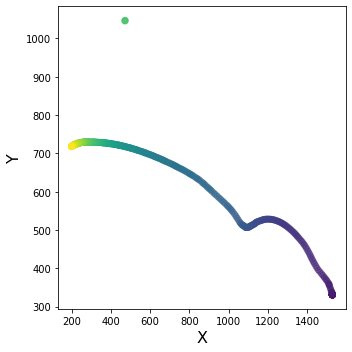

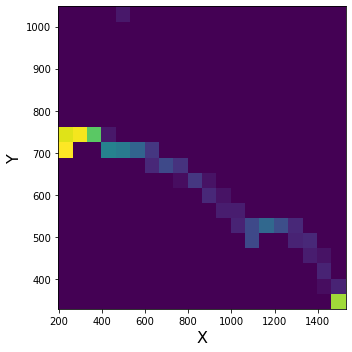

In [7]:
dx = df['pos_x'] - df['pos_x'].shift(n_inds)
dy = df['pos_y'] - df['pos_y'].shift(n_inds)
df['speed'] = np.sqrt(dx**2 + dy**2)
df.head()

In [8]:
thresh = np.array([34.5, 31.8, 33.3, 31.8])

True detection rate / individual

In [10]:
for i in np.unique(df['id']):
    print(1-len(np.where(df[df['id'] == i]['speed'] > thresh[i])[0]) / max(df['frame']))